In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l2
from keras.layers import BatchNormalization
from math import sqrt
from matplotlib import pyplot
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from scipy.stats import normaltest

## Data Preprocessing

In [17]:
# Interpolate the middle point use stochastic interpolation built by last group
def interpolate_gaussian(data, num_between, var=8):  # Data should be univariate time series in pd dataframe

    new_dat = np.zeros(1)

    for i in range(len(data)):
        new_dat = np.append(new_dat, data.iloc[i, :].values[0])
        if (i != (len(data) - 1)):
            step = (data.iloc[i + 1, :].values[0] - data.iloc[i, :].values[0]) / (num_between + 1)
            for j in range(num_between):
                k = data.iloc[i, :].values[0] + j * step + np.random.normal(loc=0.0,
                                                                            scale=1 / (var * (num_between + 1)))
                new_dat = np.append(new_dat, k)
    interpolated_data = pd.DataFrame(new_dat)
    interpolated_data = interpolated_data.iloc[1:len(interpolated_data), :]

    return (interpolated_data)


def prep_dat(d, n_step=270, n_ahead=360):  # Train a network for every step ahead (4 quarters, 8 quarters)
    # Prepare data for input/output of NNs, n_step is number of historical time steps (days) to include in regression task
    # to predict next quarter cash flows, assuming 90 days in a quarter

    a = d.copy()

    for i in range(1, n_step):
        ind = "t+" + str(i)
        a[ind] = a.iloc[:, 0].shift(-i)  # Use n_step historical observations to predict next quarter

    a["Q_Next"] = a.iloc[:, 0].shift(-(n_step + n_ahead))  # Next quarter(s) prediction

    a.dropna(
        inplace=True)  # last (n_step + n_ahead) rows will be NANs since shifting forward for "Next Quarter" Variable

    return (a)


def data_process(data, normal):
    dat = data.astype("float")
    delta = dat.shift(1)
    delta = delta.drop(delta.index[0])
    dat = dat.drop(dat.index[0])
    dat = dat.loc[~(dat==0).all(axis=1)]
    delta = delta.loc[~(delta==0).all(axis=1)]
    
    if normal == 1:
        delta = dat-delta
    else:
        delta = np.log(dat/delta)

    delta_train = interpolate_gaussian(delta.iloc[0:math.floor(0.7*len(delta))],in_between,6)
    delta_test = interpolate_gaussian(delta.iloc[math.floor(0.7*len(delta)):len(delta)],in_between,8)
    delta = pd.concat([delta_train, delta_test])
    
    return delta 

def get_macro(files, sheet,verbose = False):
    d = pd.read_excel(files, sheet_name = sheet, header = 2, usecols = "A:G",index_col = 0)[["Called Up"]]
    d = d.dropna()
    d = d.rename(columns = {'Called Up':sheet})
    
    # check distribution
    stat, p = normaltest(d)
    # interpret
    alpha = 0.05
    if p > alpha:
#         print('Statistics=%.3f, p=%.3f' % (stat, p))
        normal = 1
        if verbose:
            print('%s Sample looks Gaussian'%list(d.columns)[0])
    else:
        stat2, p2 = normaltest(np.log(d))
        if p2 > alpha:
#             print('Statistics=%.3f, p=%.3f' % (stat, p))
            normal = 2
            if verbose:
                print('%s Sample looks lognormal'%list(d.columns)[0])
        else:
            normal = 0
            if verbose:
                print("Don't know the distribution of %s Sample"%list(d.columns)[0])
      
    if normal:
        delta = data_process(d,normal)
        delta = delta.rename(columns = {0:sheet})
        return delta
    
    else:
        print("Don't know the distribution, discard factor %s"%list(d.columns)[0])
        pass

# take pd dataframe into processable numpy array
def trans_dat(data):
    pre_col = 0
    for col in data.columns:
        if pre_col == 0:
            sup_dat = prep_dat(data[[col]]).drop(columns='Q_Next').values
            sup_dat = np.expand_dims(sup_dat,axis=2)
            pre_col = col
        else:
            
            sup_dat1 = prep_dat(data[[col]]).drop(columns='Q_Next').values
            sup_dat1 = np.expand_dims(sup_dat1,axis=2)
            sup_dat = np.concatenate((sup_dat,sup_dat1),axis=2)            
            
    return sup_dat

def split_dataset_x(data):
    # split into standard weeks
    num_features = data.shape[2]
    train =  data[0:math.floor(0.7 * len(data)),0:hidden_size,0:num_features]
    test = data[math.floor(0.7 * len(data)):-1,0:hidden_size,0:num_features]
#     # restructure into windows of weekly data
#     train = array(split(train, int(len(train)/7)))
#     test = array(split(test, int(len(test)/7)))
    return train, test
# 1176/7 = 168, 546/7 = 78
def split_dataset_y(data):
    train = np.expand_dims(data[0:math.floor(0.7 * len(data))],axis = 1)
    test = np.expand_dims(data[math.floor(0.7 * len(data)):-1],axis = 1)
    return train,test


def evaluation_model(model):
    import matplotlib.pyplot as plt
    %matplotlib inline
    history = model.history
    
    y_hat_train = model.predict(X_train,verbose = 0)
    y_hat_test = model.predict(X_test,verbose = 0)
    
    train_mse = mean_squared_error(y_hat_train[:,0],y_train)
    test_mse = mean_squared_error(y_hat_test[:,0],y_test)
    
    print("Train set MSE is",train_mse)
    print("Test set MSE is",test_mse)
    
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['loss'],label = 'training loss')
    plt.plot(history.history['val_loss'],label = 'validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Training loss')
    plt.legend()
    
    
    plt.figure(figsize=(6, 3))
    plt.plot(y_hat_train[:,0],label = 'prediction')
    plt.plot(y_train,label = 'actual')
    plt.ylabel('value')
    plt.xlabel('data point')
    plt.title('Train set actual/predict')
    plt.legend()
    
    
    plt.figure(figsize=(6, 3))
    plt.plot(y_hat_test[:,0],label = 'prediction')
    plt.plot(y_test,label = 'actual')
    plt.ylabel('value')
    plt.xlabel('data point')
    plt.suptitle('Test set actual/predict')
    plt.legend()
    

filename = "Buyout_Funds_Stats_2014.xlsx"
metric = 'Called Up'
in_between = 90
#The time used to predict the future, equal to n_step in prep_dat
hidden_size = 270

In [18]:
#main data
filename = "Copy of Buyout_Funds_Stats_2014.xlsx"
dat_all = get_macro(filename, "All")


#macro factors
dat_ISMmanu = get_macro(filename, "ISMmanu")
dat_GDP = get_macro(filename, "GDP")
dat_unemployment = get_macro(filename, "unemployment")
ppi = get_macro(filename,"PPI")
ISMnonmanu = get_macro(filename,"ISMnon-manu")
nfp = get_macro(filename,"NFP")
ppi_m = get_macro(filename,"core PPI m_m")
ppi_y = get_macro(filename,"core PPI year")
retail = get_macro(filename,"retail index")
core_retail = get_macro(filename,"core retail index")
consumer_m = get_macro(filename,"consumer product index m_m")
cpi_m = get_macro(filename,"core CPI m_m")
cpi_y = get_macro(filename,"core CPI year")
new_house = get_macro(filename,"New Housing")
consumer_sentiment = get_macro(filename,"Michigan Consumer Sentiment Ind")
sale_house = get_macro(filename,"House sales")
dgo = get_macro(filename,"Durable Goods Orders m_m")
dgo_et = get_macro(filename,"DGO m_m exclude transportation")
CCI = get_macro(filename,"Conference Board's CCI")
ir = get_macro(filename,"interest rate")



Don't know the distribution, discard factor core PPI m_m
Don't know the distribution, discard factor core CPI year
Don't know the distribution, discard factor Durable Goods Orders m_m
Don't know the distribution, discard factor DGO m_m exclude transportation


## LSTM Univariate input

In [19]:
dataset = dat_all
X = trans_dat(dataset)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

In [20]:
# run again if meet exploding gradient problem and prediction will have NaN value

def build_model(train_x,train_y,n_input):
    # prepare data
#     train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 100, 100
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
#     model.add((Dense(200,  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation='relu')))
    model.add(TimeDistributed(Dense(100, activation='relu')))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.1))
    model.add(TimeDistributed(Dense(1)))
    opt = tf.keras.optimizers.Adam()
    model.compile(loss='mse', optimizer=opt)
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.25)
    return model



In [21]:
model = build_model(X_train,y_train,270)

Train set MSE is 0.0009284396928307246
Test set MSE is 0.007381578421861714


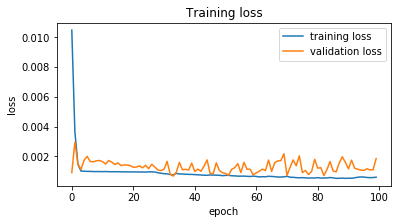

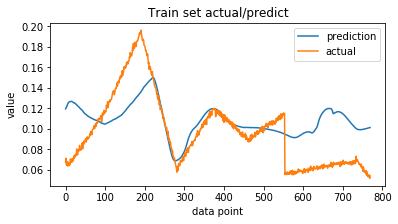

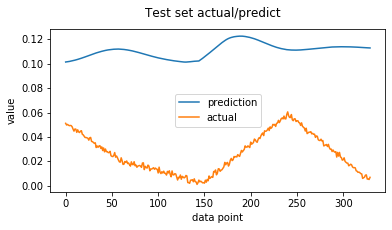

In [22]:
evaluation_model(model)

## 19 Macro factors with LSTM & encoder-decoder LSTM

In [26]:
dataset3  = pd.concat([dat_all, dat_unemployment, dat_ISMmanu, dat_GDP, ppi,
                     ISMnonmanu, nfp, ppi_m, ppi_y, retail, core_retail, consumer_m,
                       cpi_y, new_house, consumer_sentiment, 
                      sale_house, dgo, dgo_et, CCI, ir
                    ],axis = 1)

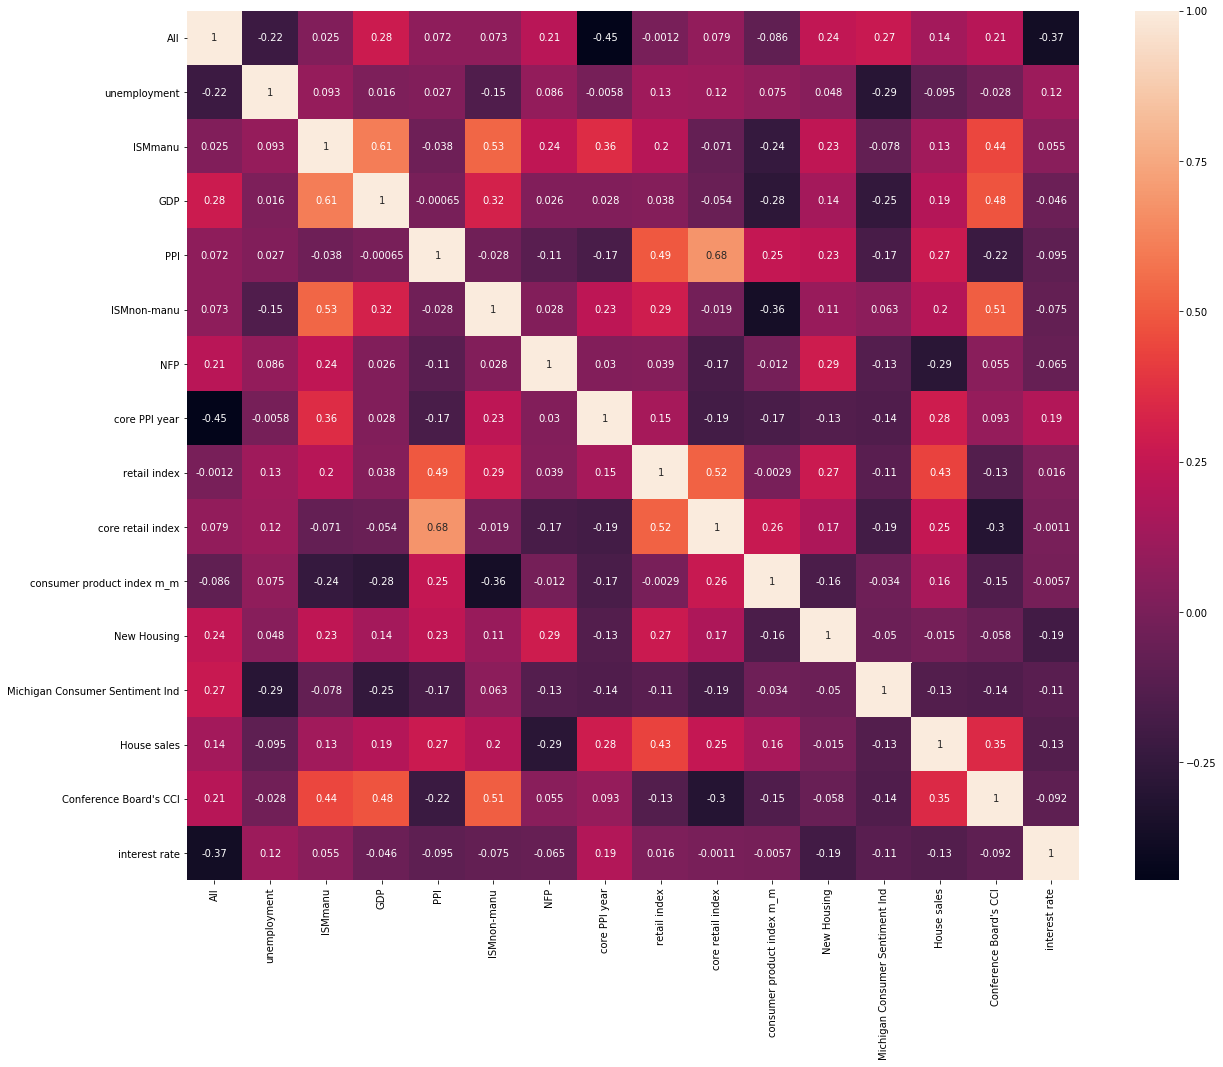

In [27]:
plt.figure(figsize = (20,16))
sn.heatmap(dataset3.corr(),annot=True)

In [25]:
X = trans_dat(dataset3)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

In [ ]:
def build_model_encoder(train_x,train_y,n_input):
    # prepare data

    # define parameters
    verbose, epochs, batch_size = 0, 100, 100
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add((Dense(200,activation='relu')))
    model.add(TimeDistributed(Dense(100, activation='relu')))
#     model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.2)
    return model



def build_model(train_x,train_y,n_input):
    # prepare data
#     train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 100, 100
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
#     model.add(RepeatVector(n_outputs))
#     model.add(LSTM(100, activation='tanh', return_sequences=True))
#     model.add((Dense(200,  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation='relu')))
    model.add((Dense(200, activation='relu')))
#     model.add(Dropout(0.1))
    model.add((Dense(n_outputs)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.2)
    return model

In [ ]:
model = build_model(X_train,y_train,270)
model_encoder = build_model_encoder(X_train,y_train,270)

In [ ]:
evaluation_model(model)

In [ ]:
evaluation_model(model_encoder)

##  feature selection on the macro factors

In [ ]:
X = trans_dat(dataset3)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
fit = pca.fit(testx)
# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(sum(fit.explained_variance_ratio_))


In [ ]:
testy = dataset3['All']
testx = dataset3.iloc[:,1:]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=9, step=10, verbose=5)
rfe_selector.fit(testx, testy)
rfe_support = rfe_selector.get_support()
rfe_feature = testx.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features',rfe_feature)

In [ ]:
dataset2 = dataset3[['All']+rfe_feature]

In [19]:
# dataset2 = pd.concat([dat_all, dat_unemployment, dat_ISMmanu, dat_GDP,ppi],axis = 1)

In [ ]:
X = trans_dat(dataset2)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

In [ ]:
model = build_model(X_train,y_train,270)
model_encoder = build_model_encoder(X_train,y_train,270)

Train set MSE is 0.0007084369242327156
Test set MSE is 0.0048245686716225054


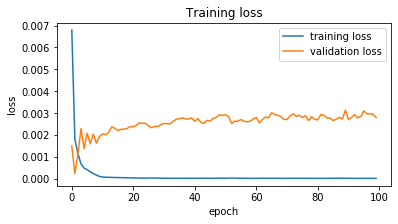

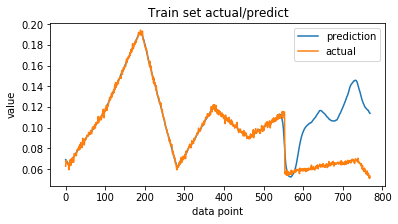

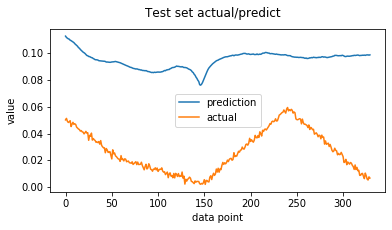

In [22]:
evaluation_model(model)

Train set MSE is 0.00039101391721272705
Test set MSE is 0.004455475674695021


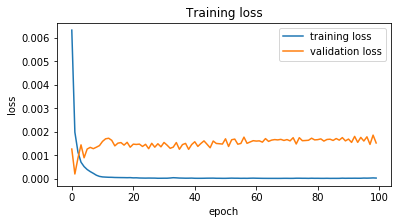

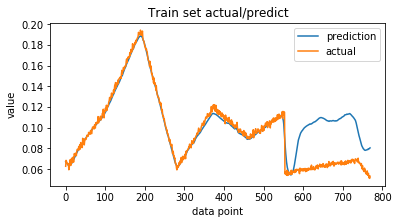

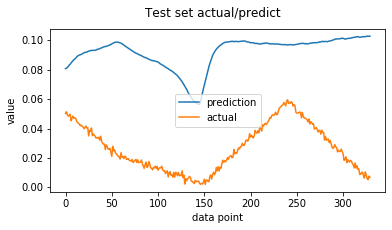

In [23]:
evaluation_model(model_encoder)

## CNN encoder-decoder LSTM univariate

In [24]:
dataset = dat_all
X = trans_dat(dataset)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

In [25]:
def build_model_conv(train_x,train_y,n_input):
    # prepare data
#     train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 100, 100
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.25)
    return model

In [26]:
model = build_model_conv(X_train,y_train,270)

Train set MSE is 6.321542563823418e-05
Test set MSE is 0.002630753963345492


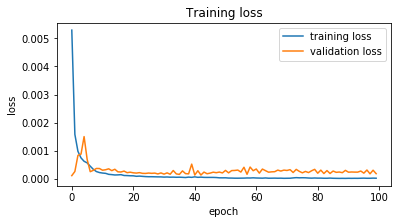

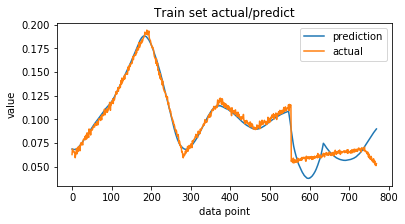

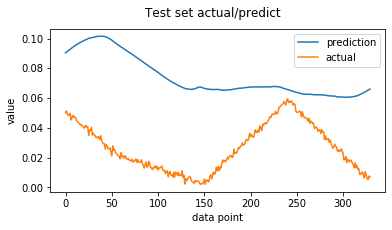

In [27]:
evaluation_model(model)

## CNN encoder-decoder LSTM multivariate

In [ ]:
def build_model_conv1(train_x,train_y,n_input):
    # prepare data
#     train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 100, 100
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')

    
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.25)
    return model

In [ ]:
X = trans_dat(dataset3)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)
print(X_train.shape,'\n',y_train.shape)

In [ ]:
model = build_model_conv1(X_train,y_train,270)
evaluation_model(model)

## Conv 2-d

Unlike an LSTM that reads the data in directly in order to calculate internal state and state transitions, and unlike the CNN-LSTM that is interpreting the output from CNN models, the ConvLSTM is using convolutions directly as part of reading input into the LSTM units themselves.

In [ ]:
def prep_dat(d, n_step=270, n_ahead=360):  # Train a network for every step ahead (4 quarters, 8 quarters)
    # Prepare data for input/output of NNs, n_step is number of historical time steps (days) to include in regression task
    # to predict next quarter cash flows, assuming 90 days in a quarter

    a = d.copy()

    for i in range(1, n_step):
        ind = "t+" + str(i)
        a[ind] = a.iloc[:, 0].shift(-i)  # Use n_step historical observations to predict next quarter

    a["Q_Next"] = a.iloc[:, 0].shift(-(n_step + n_ahead))  # Next quarter(s) prediction

    a.dropna(
        inplace=True)  # last (n_step + n_ahead) rows will be NANs since shifting forward for "Next Quarter" Variable

    return (a)


def evaluation_model_conv(model,X_train,X_test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    history = model.history
    
    n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
    X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))
    y_hat_train = model.predict(X_train,verbose = 0)
    y_hat_test = model.predict(X_test,verbose = 0)
    
    train_mse = mean_squared_error(y_hat_train[:,0],y_train)
    test_mse = mean_squared_error(y_hat_test[:,0],y_test)
    
    print("Train set MSE is",train_mse)
    print("Test set MSE is",test_mse)
    
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['loss'],label = 'training loss')
    plt.plot(history.history['val_loss'],label = 'validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Training loss')
    plt.legend()
    
    
    plt.figure(figsize=(6, 3))
    plt.plot(y_hat_train[:,0],label = 'prediction')
    plt.plot(y_train,label = 'actual')
    plt.ylabel('value')
    plt.xlabel('data point')
    plt.title('Train set actual/predict')
    plt.legend()
    
    
    plt.figure(figsize=(6, 3))
    plt.plot(y_hat_test[:,0],label = 'prediction')
    plt.plot(y_test,label = 'actual')
    plt.ylabel('value')
    plt.xlabel('data point')
    plt.suptitle('Test set actual/predict')
    plt.legend()

#The time used to predict the future, equal to n_step in prep_dat
hidden_size = 270
n_steps, n_length = 90,3

In [ ]:
X = trans_dat(dataset3)
y = prep_dat(dat_all)['Q_Next']
X_train, X_test = split_dataset_x(X)
y_train, y_test = split_dataset_y(y)

In [ ]:
def build_model_conv2(train_x,train_y,n_input):
    # prepare data
#     train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 100, 100
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # define model

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    
#     model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
#     model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')

    
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.25)
    return model

In [ ]:
model = build_model_conv2(X_train,y_train,270)

In [ ]:
evaluation_model_conv(model,X_train,X_test)

## Use autoencoder to compress the data after interpolation

In [ ]:

# lstm autoencoder recreate sequence
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
# define input sequence

sequence = dat_all.values
n_in = len(sequence)
sequence = sequence.reshape((1, n_in, 1))
# reshape input into [samples, timesteps, features]
def amodel1(sequence):

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_in,1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_in))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')

    # define model
    # model = Sequential()
    # model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
    # model.add(RepeatVector(n_in))
    # model.add(LSTM(100, activation='relu', return_sequences=True))
    # model.add(TimeDistributed(Dense(1)))
    # model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(sequence, sequence, epochs=100, verbose=0)
    # demonstrate recreation
    return model



def amodel2(sequence):


    # define model
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(n_in,1)))
#     model.add(RepeatVector(n_in))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(sequence, sequence, epochs=100, verbose=0)
    # demonstrate recreation
    return model
    

In [ ]:
model2 = amodel2(sequence)

In [ ]:
yhat = model2.predict(sequence)
mean_squared_error(yhat[0,:,0],sequence[0,:,0])



In [ ]:
plt.plot(yhat[0,:,0],label = 'predict')
plt.plot(sequence[0,:,0], label = 'true')
plt.legend()

In [ ]:
yhat

In [ ]:
sequence

In [ ]:
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores


In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
# def to_supervised(train, n_input, n_out=1):
#     # flatten data
#     data = train.reshape((train.shape[0], train.shape[1]))
#     X, y = list(), list()
#     in_start = 0
#     # step over the entire history one time step at a time
#     for _ in range(len(data)):
#         # define the end of the input sequence
#         in_end = in_start + n_input
#         out_end = in_end + n_out
#         # ensure we have enough data for this instance
#         if out_end <= len(data):
#             X.append(data[in_start:in_end, :])
#             y.append(data[in_end:out_end, 0])
#         # move along one time step
#         in_start += 1
#     return array(X), array(y)

In [ ]:
data = train.reshape((train.shape[0],train.shape[1]))

In [ ]:
# x_sup,y_sup = to_supervised(train, 270, 1)
# x_sup.shape

In [ ]:
# n_input = 270
# n_out = 1
# X, y = list(), list()
# in_start = 0
#     # step over the entire history one time step at a time
# for _ in range(len(data)):
#     # define the end of the input sequence
#     in_end = in_start + n_input
#     out_end = in_end + n_out
#     # ensure we have enough data for this instance
#     if out_end <= len(data):
#         X.append(data[in_start:in_end, :])
#         y.append(data[in_end:out_end, 0])
#     # move along one time step
#     in_start += 1

In [ ]:
data  #0.0885036

In [ ]:
X[0].shape

In [ ]:
train_x, train_y = to_supervised(train, n_input)

In [ ]:
train_x.shape

In [ ]:
# X shape: 270 * 4
# num of train: 817
# y shape: 90 * 1

In [ ]:
# train_x , train_y =  to_supervised(train, n_input)

In [ ]:
# train_x.shape

In [ ]:
# train_y

In [ ]:
# train_x[0]

In [ ]:
train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

In [ ]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

In [ ]:
print(n_timesteps, n_features, n_outputs)

In [ ]:
# train_x , train_y =  to_supervised(train, n_input)

In [ ]:
# train_y[0]

In [ ]:
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0], data.shape[1]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [ ]:
data = array(history)
data = data.reshape((data.shape[0], data.shape[1]))
# retrieve last observations for input data
input_x = data[-n_input:, :]
# reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
# forecast the next week
yhat = model.predict(input_x, verbose=0)

In [ ]:
yhat

In [ ]:
build_model(train, 270)

In [ ]:
history = [x for x in train]
    # walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)


In [ ]:
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

In [ ]:
actual, predicted = test, predictions
scores = list()
# calculate an RMSE score for each day
for i in range(actual.shape[1]):        # 
    # calculate mse
    mse = mean_squared_error(actual[:, i], predicted[:, i])
    # calculate rmse
    rmse = sqrt(mse)
    # store
    scores.append(rmse)
# calculate overall RMSE
s = 0
for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
        s += (actual[row, col] - predicted[row, col])**2
score = sqrt(s / (actual.shape[0] * actual.shape[1]))

In [ ]:
test

In [ ]:
actual[:]

In [ ]:
predicted

In [ ]:
actual

In [ ]:
predictions.shape

In [ ]:
test.shape

In [ ]:
predictions.shape

In [ ]:
len(predictions)

In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):        # 
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [ ]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed



datasets = dataset
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 270


In [ ]:
score, scores = evaluate_model(train, test, n_input)

In [ ]:
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [ ]:
from math import *

In [ ]:

4096*2/3/16

In [ ]:
log(10**9 / 171,171)

In [ ]:
10**9

In [ ]:
(10**9)*80 / 4096

In [ ]:
1.95*10**7

In [ ]:
4096 * 2/3 / (32+8)

In [ ]:
((2/3) * 4 * 1024 ) / 40

In [ ]:
10**9 / 171

In [ ]:
log(10**9*3*(16)/(4096*2),171)

In [ ]:
log(10**9*3*(40)/(4096*2),68)

In [ ]:
10**9/171

In [ ]:
log(10**9/171,171)

In [ ]:
10**9/68

In [ ]:
log(10**9/68,68)

In [ ]:
10**9*40/(4*1024*2/3)

In [ ]:
10**9 / (4096 * 2/3 / (32+8))